In [2]:
import os
import glob

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import cv2

from keras.preprocessing import image
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.layers import Input, Dense, Activation, BatchNormalization, Flatten, Conv2D
from keras.layers import MaxPooling2D, Dropout, UpSampling2D

Using TensorFlow backend.


In [0]:
%matplotlib inline

In [4]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


(420, 540)


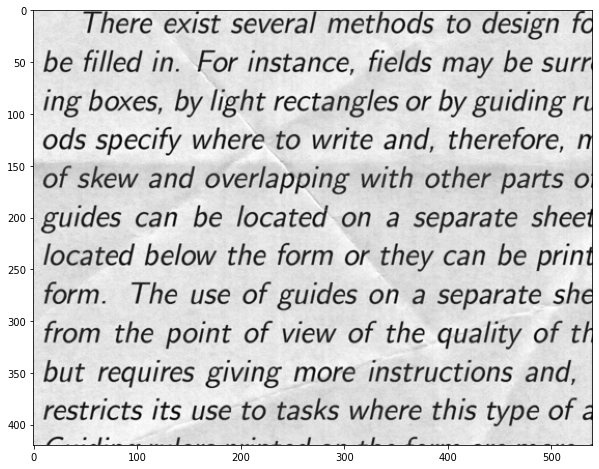

In [5]:
plt.figure(figsize=(20,8))
img = cv2.imread('/content/drive/My Drive/101.png', 0)
plt.imshow(img, cmap='gray')
print(img.shape)

In [0]:
TRAIN_IMAGES = glob.glob('/content/drive/My Drive/Denoise/train/*.png')
CLEAN_IMAGES = glob.glob('/content/drive/My Drive/Denoise/train_cleaned/*.png')
TEST_IMAGES = glob.glob('/content/drive/My Drive/Denoise/test/*.png')

In [0]:
def load_image(path):
    image_list = np.zeros((len(path), 258, 540, 1))
    for i, fig in enumerate(path):
        img = image.load_img(fig, color_mode='grayscale', target_size=(258, 540))
        x = image.img_to_array(img).astype('float32')
        x = x / 255.0
        image_list[i] = x
    
    return image_list

In [8]:
x_train = load_image(TRAIN_IMAGES)
y_train = load_image(CLEAN_IMAGES)
x_test = load_image(TEST_IMAGES)

print(x_train.shape, x_test.shape)

(144, 258, 540, 1) (72, 258, 540, 1)


In [9]:
def train_val_split(x_train, y_train):
    rnd = np.random.RandomState(seed=42)
    perm = rnd.permutation(len(x_train))
    train_idx = perm[:int(0.8 * len(x_train))]
    val_idx = perm[int(0.8 * len(x_train)):]
    return x_train[train_idx], y_train[train_idx], x_train[val_idx], y_train[val_idx]

x_train, y_train, x_val, y_val = train_val_split(x_train, y_train)
print(x_train.shape, x_val.shape)

(115, 258, 540, 1) (29, 258, 540, 1)


In [0]:
class Autoencoder():
    def __init__(self):
        self.img_rows = 258
        self.img_cols = 540
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        
        optimizer = Adam(lr=0.001)
        
        self.autoencoder_model = self.build_model()
        self.autoencoder_model.compile(loss='mse', optimizer=optimizer)
        self.autoencoder_model.summary()
    
    def build_model(self):
        input_layer = Input(shape=self.img_shape)
        
        # encoder
        h = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
        h = MaxPooling2D((2, 2), padding='same')(h)
        
        # decoder
        h = Conv2D(64, (3, 3), activation='relu', padding='same')(h)
        h = UpSampling2D((2, 2))(h)
        output_layer = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(h)
        
        return Model(input_layer, output_layer)
    
    def train_model(self, x_train, y_train, x_val, y_val, epochs, batch_size=20):
        early_stopping = EarlyStopping(monitor='val_loss',
                                       min_delta=0,
                                       patience=5,
                                       verbose=1, 
                                       mode='auto')
        history = self.autoencoder_model.fit(x_train, y_train,
                                             batch_size=batch_size,
                                             epochs=epochs,
                                             validation_data=(x_val, y_val),
                                             callbacks=[early_stopping])
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='upper left')
        plt.show()
    
    def eval_model(self, x_test):
        preds = self.autoencoder_model.predict(x_test)
        return preds

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 258, 540, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 258, 540, 64)      640       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 129, 270, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 129, 270, 64)      36928     
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 258, 540, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 258, 540, 1)       577       
Total params: 38,145
Trainable params: 38,145
Non-trainable params: 0
_______________________________________________________

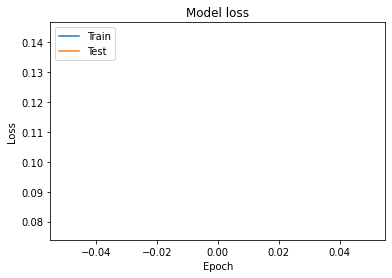

In [11]:
ae = Autoencoder()
ae.train_model(x_train, y_train, x_val, y_val, epochs=1, batch_size=20)

In [0]:
preds = ae.eval_model(x_test)

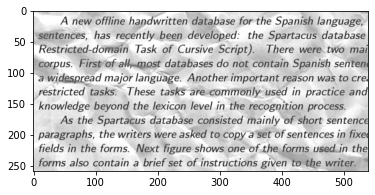

In [13]:
preds_0 = preds[10] * 255.0
preds_0 = preds_0.reshape(258, 540)
x_test_0 = x_test[10] * 255.0
x_test_0 = x_test_0.reshape(258, 540)
plt.imshow(x_test_0, cmap='gray')

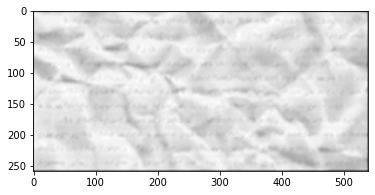

In [14]:
plt.imshow(preds_0, cmap='gray')

In [0]:
preds = preds.reshape(-1, 258, 540)

In [16]:
ids = []
vals = []
for i, f in enumerate(TEST_IMAGES):
    file = os.path.basename(f)
    imgid = int(file[:-4])
    test_img = cv2.imread(f, 0)
    img_shape = test_img.shape
    print('processing: {}'.format(imgid))
    print(img_shape)
    preds_reshaped = cv2.resize(preds[i], (img_shape[1], img_shape[0]))
    for r in range(img_shape[0]):
        for c in range(img_shape[1]):
            ids.append(str(imgid)+'_'+str(r + 1)+'_'+str(c + 1))
            vals.append(preds_reshaped[r, c])

print('Writing to csv file')
pd.DataFrame({'id': ids, 'value': vals}).to_csv('submission.csv', index=False)

processing: 82
(420, 540)
processing: 55
(258, 540)
processing: 79
(420, 540)
processing: 22
(258, 540)
processing: 67
(258, 540)
processing: 70
(258, 540)
processing: 1
(258, 540)
processing: 10
(258, 540)
processing: 49
(258, 540)
processing: 25
(258, 540)
processing: 34
(258, 540)
processing: 64
(258, 540)
processing: 16
(258, 540)
processing: 40
(258, 540)
processing: 4
(258, 540)
processing: 88
(420, 540)
processing: 52
(258, 540)
processing: 31
(258, 540)
processing: 19
(258, 540)
processing: 43
(258, 540)
processing: 37
(258, 540)
processing: 46
(258, 540)
processing: 7
(258, 540)
processing: 61
(258, 540)
processing: 73
(420, 540)
processing: 28
(258, 540)
processing: 13
(258, 540)
processing: 85
(420, 540)
processing: 58
(258, 540)
processing: 91
(420, 540)
processing: 76
(420, 540)
processing: 109
(420, 540)
processing: 139
(420, 540)
processing: 154
(420, 540)
processing: 121
(420, 540)
processing: 160
(420, 540)
processing: 145
(420, 540)
processing: 112
(420, 540)
processi

In [17]:
print(len(ids))

14230080
